In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
import pandas as pd
import os
import dotenv
import matplotlib.pyplot as plt
import seaborn as sns
dotenv.load_dotenv()
import sys
sys.path.append('../src')

In [12]:
from load_data import DataIngestorFactory

In [14]:
data_ingestor = DataIngestorFactory().get_data_ingestor(file_extension="db")
table_name = "diabetes"
if data_ingestor:
    df: pd.DataFrame | None = data_ingestor.ingest(
        db_name=os.getenv("MYSQL_DATABASE"),
        table_name=table_name,
        db_password=os.getenv("MYSQL_PASSWORD"),
        db_host="localhost",
    )

2024-12-24 11:56:46.254 | INFO     | load_data:connect_database:42 - Database connected successfully.


In [15]:
df.head()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0


### Description of Dataset
This dataset is originally from the `National Institute of Diabetes and Digestive and Kidney Diseases`. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

### Content
The datasets consists of several medical predictor variables and one target variable, Outcome.

Predictor variables includes:
1. The number of pregnancies the patient has had.
4. Plasma Glucose or commonly known as blood sugar measured in mg/dl (milligram/deciliter) Note: 1 deciliter = 100 milliliter.
5. Diastolic Blood Pressure. According to google: `The bottom number in a blood pressure reading, which measures the force of blood in your arteries when your heart is relaxed between beats.`
6. Triceps Thickness. According to google: `A measurement of subcutaneous fat(fat that is stored under your skin and can be pinched.) in the limbs and is used to estimate total body fat composition.`
7. Serum Insuline: According to google: `A measurement of the amount of insulin in a person's blood.`
8. BMI
3. Diabetes Pedigree. According to google: `A family tree that shows the diabetes status of each family member, as well as other relevant information. A diabetes pedigree can be used to calculate the likelihood of a person developing diabetes based on their family history and age. This calculation is called the Diabetes Pedigree Function (DPF), and it produces a score that ranges from 0.08 to 2.42. A higher DPF score indicates a higher likelihood of developing diabetes.`
4. Age


In [10]:
df.describe()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
count,1.000000e+04,10000.00000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.502122e+06,3.25580,107.850200,71.207500,28.81760,139.243600,31.567022,0.400944,30.134100,0.334400
std,2.892868e+05,3.40572,31.920909,16.801478,14.50648,133.777919,9.804366,0.381463,12.106047,0.471804
min,1.000038e+06,0.00000,44.000000,24.000000,7.00000,14.000000,18.200807,0.078044,21.000000,0.000000
25%,1.251672e+06,0.00000,84.000000,58.000000,15.00000,39.000000,21.247427,0.137065,22.000000,0.000000
50%,1.504394e+06,2.00000,105.000000,72.000000,31.00000,85.000000,31.922421,0.199698,24.000000,0.000000
75%,1.754608e+06,6.00000,129.000000,85.000000,41.00000,197.000000,39.328921,0.621158,35.000000,1.000000
max,1.999997e+06,14.00000,192.000000,117.000000,92.00000,796.000000,56.034628,2.301594,77.000000,1.000000


In [20]:
import numpy as np

<Axes: xlabel='PlasmaGlucose', ylabel='BMI'>

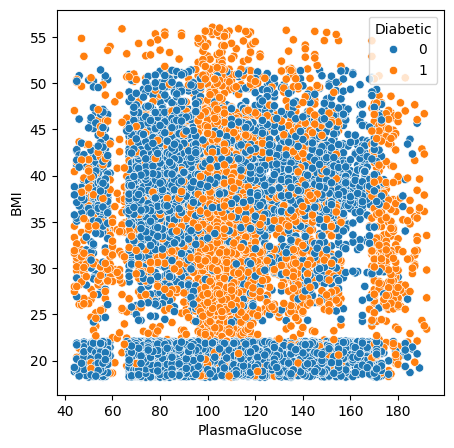

In [22]:
plt.figure(figsize=(5,5))
sns.scatterplot(data=df,x="PlasmaGlucose",y="BMI",hue="Diabetic")